# **Bonus: Les Visions Transformes (ViT) pour la classification d'images forestières**

# **1. Vérifier que le GPU est bien sélectionné** ##

In [1]:
!nvidia-smi

Sat Nov 23 10:38:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **2. Installation des librairies spécifiques aux ViT** ##

In [2]:
!pip install fsspec==2024.9.0
!pip install -q transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00


# **3. Importation des libraries** ##

In [3]:
import os
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from PIL import Image
from transformers import ViTFeatureExtractor
from torchvision.transforms import Compose, Normalize, RandomResizedCrop, RandomHorizontalFlip, Resize, CenterCrop, ToTensor
import torch
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer

# **4. Téléchargement du jeu de données d'entraînement** ##

In [4]:
!rm -rf sample_data
!wget https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_3.zip
!mkdir -p FIRE/train
!unzip FIRE_DATABASE_3.zip -d FIRE/train
!rm FIRE_DATABASE_3.zip

--2024-11-23 10:39:55--  https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_3.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 466235525 (445M) [application/zip]
Saving to: ‘FIRE_DATABASE_3.zip’

FIRE_DATABASE_3.zip 100%[===================>] 444.64M  16.9MB/s    in 44s     

2024-11-23 10:40:41 (10.1 MB/s) - ‘FIRE_DATABASE_3.zip’ saved [466235525/466235525]

Archive:  FIRE_DATABASE_3.zip
   creating: FIRE/train/FIRE_DATABASE_3/
   creating: FIRE/train/FIRE_DATABASE_3/fire/
  inflating: FIRE/train/FIRE_DATABASE_3/fire/00000000.jpg  
  inflating: FIRE/train/FIRE_DATABASE_3/fire/00000001.jpg  
  inflating: FIRE/train/FIRE_DATABASE_3/fire/00000003.jpg  
  inflating: FIRE/train/FIRE_DATABASE_3/fire/00000004.jpg  
  inflating: FIRE/train/FIRE_DATABASE_3/fire/00000005.jpg  
  infl

# **4.1 Téléchargement du jeu de données de test** ##

In [5]:
!wget https://nextcloud.ig.umons.ac.be/s/XqEMQtqQNPoG2cY/download/test.zip
!unzip test.zip -d FIRE/test
!rm test.zip

--2024-11-23 10:40:46--  https://nextcloud.ig.umons.ac.be/s/XqEMQtqQNPoG2cY/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57038454 (54M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  54.40M  9.23MB/s    in 6.4s    

2024-11-23 10:40:54 (8.53 MB/s) - ‘test.zip’ saved [57038454/57038454]

Archive:  test.zip
   creating: FIRE/test/test/
   creating: FIRE/test/test/fire/
  inflating: FIRE/test/test/fire/F_1001.jpg  
  inflating: FIRE/test/test/fire/F_2062.jpg  
  inflating: FIRE/test/test/fire/F_2063.jpg  
  inflating: FIRE/test/test/fire/F_2064.jpg  
  inflating: FIRE/test/test/fire/F_2066.jpg  
  inflating: FIRE/test/test/fire/F_2067.jpg  
  inflating: FIRE/test/test/fire/F_2068.jpg  
  inflating: FIRE/test/test/fire/F_2070.jpg  
  inflatin

# **5. Création des datasets train, validation et test** ##

In [6]:
train_dir = 'FIRE/train/FIRE_DATABASE_3'
test_dir = 'FIRE/test/test'

classes = ['fire', 'no_fire', 'start_fire']
train_data, train_labels = [], []
test_data, test_labels = [], []

# Parcourir les dossiers d'entraînement pour charger les images avec les labels correspondants
for label in classes:
    folder_path = os.path.join(train_dir, label)
    for img_name in os.listdir(folder_path):
        train_data.append(os.path.join(folder_path, img_name))
        train_labels.append(label)

# Parcourir les dossiers de test pour charger les images avec les labels correspondants
for label in classes:
    folder_path = os.path.join(test_dir, label)
    for img_name in os.listdir(folder_path):
        test_data.append(os.path.join(folder_path, img_name))
        test_labels.append(label)

# Créer des dataframes pour train, validation et test
df = pd.DataFrame({'image': train_data, 'label': train_labels})
test_df = pd.DataFrame({'image': test_data, 'label': test_labels})
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])

# Créer des datasets à partir des dataframes
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# **5. Choix du ViT et définition des transformation des images dans chaque dataset** ##

In [7]:
MODEL_NAME = 'google/vit-base-patch16-224-in21k'

In [8]:
# Charger le Feature Extractor pour ViT
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)

# Définir la taille des images
img_size = feature_extractor.size['height']


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

_train_transforms = Compose([
    RandomResizedCrop(img_size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize(img_size),
    CenterCrop(img_size),
    ToTensor(),
    normalize,
])

_val_test_transforms = Compose([
    Resize(img_size),
    CenterCrop(img_size),
    ToTensor(),
    normalize,
])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# **5.1 Application des transformations dans chaque dataset** ##

In [9]:
# Fonction pour charger une image
def load_image(image_path):
    return Image.open(image_path)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(load_image(image_path).convert("RGB")) for image_path in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(load_image(image_path).convert("RGB")) for image_path in examples['image']]
    return examples

def val_test_transforms(examples):
    examples['pixel_values'] = [_val_test_transforms(load_image(image_path).convert("RGB")) for image_path in examples['image']]
    return examples

# Appliquer les transformations sur le dataset
datasets['train'] = datasets['train'].map(train_transforms, batched=True)
datasets['validation'] = datasets['validation'].map(val_transforms, batched=True)
datasets['test'] = datasets['test'].map(val_test_transforms, batched=True)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

# **5.2 Préparation du dataloader pour l'entrainenement, la validation et le test** ##

In [10]:
train_dataloader = DataLoader(datasets['train'], batch_size=8, shuffle=True)
val_dataloader = DataLoader(datasets['validation'], batch_size=8)
test_dataloader = DataLoader(datasets['test'], batch_size=8)

In [11]:
label2id = {'fire': 0, 'no_fire': 1, 'start_fire': 2}
datasets = datasets.map(lambda e: {'label': [label2id[label] for label in e['label']]}, batched=True)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

# **6. Chargement du modèle pré-entrainé ViT et configuration de ses arguments d'entrainement** ##

In [12]:
model = ViTForImageClassification.from_pretrained(MODEL_NAME, num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['validation'],
    compute_metrics=compute_metrics
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# Calcul du nombre de paramètres
num_params = sum(p.numel() for p in model.parameters())
model_size_mb = num_params * 4 / (1024 ** 2)
print(f"Taille du modèle : {num_params} paramètres ({model_size_mb:.2f} Mo)")

Taille du modèle : 85800963 paramètres (327.30 Mo)


# **6.1 Entrainement du modèle** ##

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.279700,0.107759,0.976667
2,0.081700,0.086054,0.976667
3,0.030700,0.080454,0.976667
4,0.016300,0.111979,0.973333
5,0.009400,0.106833,0.973333
6,0.008000,0.137917,0.970000
7,0.006400,0.096787,0.980000
8,0.005900,0.098676,0.976667
9,0.005400,0.100117,0.976667
10,0.005300,0.100578,0.976667


TrainOutput(global_step=1500, training_loss=0.05773851755013069, metrics={'train_runtime': 2022.0665, 'train_samples_per_second': 5.935, 'train_steps_per_second': 0.742, 'total_flos': 9.29912209809408e+17, 'train_loss': 0.05773851755013069, 'epoch': 10.0})

# **7. Matrice de confusion sur le dataset de validation** ##

{'test_loss': 0.0804535374045372, 'test_accuracy': 0.9766666666666667, 'test_runtime': 34.3315, 'test_samples_per_second': 8.738, 'test_steps_per_second': 1.107}


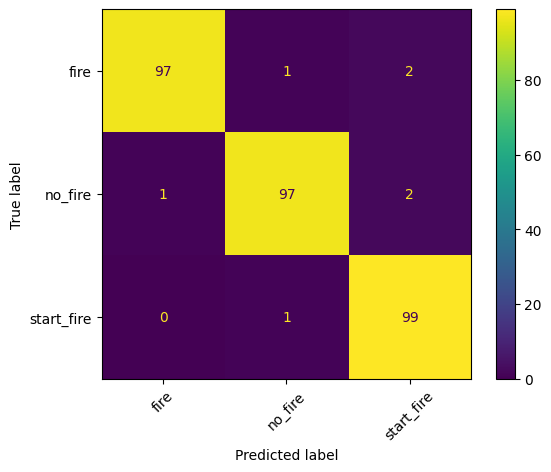

In [16]:
outputs = trainer.predict(datasets['validation'])
print(outputs.metrics)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = classes
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

# **7.1 Matrice de confusion sur le dataset de test** ##

{'test_loss': 0.22731022536754608, 'test_accuracy': 0.9366666666666666, 'test_runtime': 32.3711, 'test_samples_per_second': 9.268, 'test_steps_per_second': 1.174}


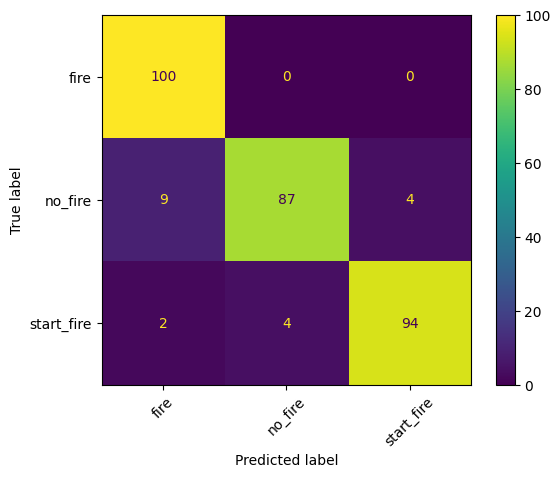

In [17]:
test_outputs = trainer.predict(datasets['test'])
print(test_outputs.metrics)

y_test_true = test_outputs.label_ids
y_test_pred = test_outputs.predictions.argmax(1)
cm_test = confusion_matrix(y_test_true, y_test_pred)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classes)
disp_test.plot(xticks_rotation=45)

# **8. Fonction de test du modèle sur une image importée** ##

In [18]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)

def predict_image(image_path, trained_model, class_names):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {key: value.to(trained_model.device) for key, value in inputs.items()}  # Sur GPU si disponible
    # Passer en mode évaluation
    trained_model.eval()
    with torch.no_grad():
        outputs = trained_model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()

    return class_names[predicted_class_idx], image, predicted_class_idx

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# **8.1 Test avec une image fire donnée en entrée** ##

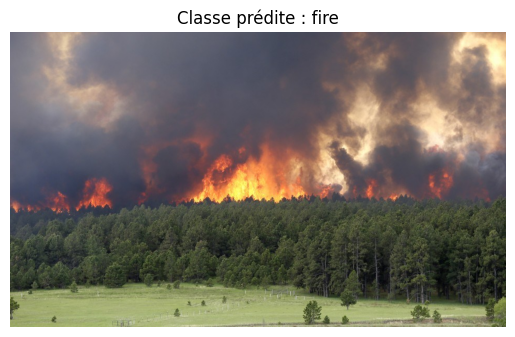

In [19]:
image_path = "fire.jpg"
predicted_class = predict_image(image_path, trainer.model, classes)
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.title(f"Classe prédite : {predicted_class[0]}")
plt.axis("off")
plt.show()

# **8.2 Test avec une image no_fire donnée en entrée** ##

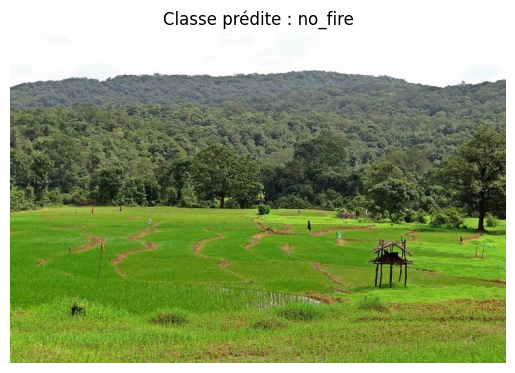

In [20]:
image_path = "no_fire.jpg"
predicted_class = predict_image(image_path, trainer.model, classes)
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.title(f"Classe prédite : {predicted_class[0]}")
plt.axis("off")
plt.show()

# **8.3 Test avec une image start_fire donnée en entrée** ##

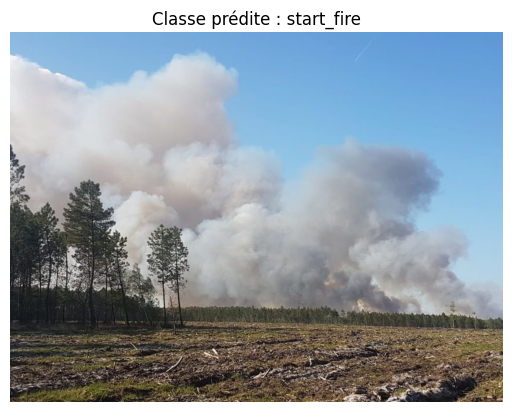

In [21]:
image_path = "start_fire.jpg"
predicted_class = predict_image(image_path, trainer.model, classes)
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.title(f"Classe prédite : {predicted_class[0]}")
plt.axis("off")
plt.show()

# **9. Téléchargement de la base de données pour faire le fichier csv à déposer sur Kaggle** ##

In [22]:
!wget https://nextcloud.ig.umons.ac.be/s/rYnCgdSmmRerJRa/download/TestData.zip
!unzip TestData.zip -d test_data

--2024-11-23 11:17:43--  https://nextcloud.ig.umons.ac.be/s/rYnCgdSmmRerJRa/download/TestData.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433130624 (413M) [application/zip]
Saving to: ‘TestData.zip’

TestData.zip        100%[===================>] 413.07M  14.2MB/s    in 34s     

2024-11-23 11:18:19 (12.0 MB/s) - ‘TestData.zip’ saved [433130624/433130624]

Archive:  TestData.zip
   creating: test_data/TestData/
  inflating: test_data/TestData/43.jpg  
  inflating: test_data/TestData/46.jpg  
  inflating: test_data/TestData/69.jpg  
  inflating: test_data/TestData/77.jpg  
  inflating: test_data/TestData/80.jpg  
  inflating: test_data/TestData/85.jpg  
  inflating: test_data/TestData/86.jpg  
  inflating: test_data/TestData/91.jpg  
  inflating: test_data/TestData/94.jpg  
  inflating: test_d

# **9.1 Création du CSV à soumettre sur Kaggle** ##

In [25]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)

class_names = ['fire', 'no_fire', 'start_fire']
folder_path = 'test_data/TestData'

predictions = []
filenames = []


# Prédiction pour chaque image dans le dossier
for img_path in os.listdir(folder_path):
    if img_path.endswith(('.jpg', '.jpeg', '.png')):
        image_full_path = os.path.join(folder_path, img_path)
        predicted_class_idx = predict_image(image_full_path, trained_model=model, class_names=class_names)[2]
        predictions.append(predicted_class_idx)
        filenames.append(img_path)

# Créer un dataframe pour la soumission
submission_df = pd.DataFrame({
    'ID': filenames,
    'Label': predictions
})

# Sauvegarder dans un fichier CSV
submission_df.to_csv('submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# **10. Résultats** ##

Après soumission nous avons obtenu la note de 0.839 sur Kaggle.